# ASG Quant Fund Project

#### Armaan Gandhara

## Week 1

### Data Loader Development

In [2]:
import yfinance as yf
import pandas as pd
from typing import List
import os
import json

In [3]:
class data_loader:

    def __init__(self):
        self.raw_path = "./data/raw"
        self.processed_path = "./data/processed"

    def _raw_filepath(self, ticker: str) -> str:
        return os.path.join(self.raw_path, f"{ticker}.csv")

    def get_data(self, ticker: str, start: str, end: str) -> pd.DataFrame:
        ticker = ticker.replace('.', '-')

        filepath = self._raw_filepath(ticker)

        if os.path.exists(filepath):
            data = pd.read_csv(filepath, index_col='Date', parse_dates=True)
            sliced_data = data.loc[start:end]
            print(f"Retrieving {ticker} data from csv")
            if not sliced_data.empty:
                return sliced_data

        print(f"Downloading {ticker} from yfinance...")
        data = yf.download(ticker, start=start, end=end, progress=False)
        if data.empty:
            print(f"[!] Failed to download {ticker}. Skipping.")
            return None
        data.dropna(inplace=True)
        if 'Adj Close' in data.columns:
            data.drop(columns=['Adj Close'], inplace=True)
        #data.rename(columns={'Open': 'open','High': 'high','Low': 'low','Close': 'close','Volume': 'volume'}, inplace=True)
        #required_cols = ['open', 'high', 'low', 'close', 'volume']
        #data = data[required_cols]
        data = data.droplevel('Ticker', axis=1)
        data.reset_index(inplace=True)
        data.index = data['Date']
        del data['Date']
        data.index.name = 'Date'
        data.to_csv(filepath)
        return data.loc[start:end]


    def get_multiple_data(self, tickers: List[str], start: str, end: str) -> dict:
        data_dict = {}
        for ticker in tickers:
            df = self.get_data(ticker, start, end)
            if df is not None:
                data_dict[ticker] = df

        return data_dict
    
    def get_sp500_data(self, start: str, end: str):
        sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
        sp500 = sp500['Symbol'].to_list()
        data = self.get_multiple_data(sp500, start, end)
        return data

    def get_sp500_data_df(self, start: str, end: str) -> pd.DataFrame:
        tickers = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]['Symbol'].tolist()
        tickers = [t.replace('.', '-') for t in tickers]
        data_dict = self.get_multiple_data(tickers, start, end)
        close_prices = [df[['Close']].rename(columns={'Close': ticker}) for ticker, df in data_dict.items()]
        return pd.concat(close_prices, axis=1) if close_prices else pd.DataFrame()
    
    def get_fundamentals(self, ticker):
        ticker = ticker.replace('.', '-')
        file_path = os.path.join(self.raw_path, f"{ticker}_fundamentals.json")

        if os.path.exists(file_path):
            try:
                with open(file_path, 'r') as f:
                    fundamentals = json.load(f)
                print(f"[!] Loading fundamentals from file for {ticker}")
                return fundamentals
            except Exception as e:
                print(f"[!] Failed to load fundamentals from file for {ticker}: {e}")

        try:
            print(f"[i] Downloading fundamentals for {ticker} from Yahoo Finance... ")
            fundamentals = yf.Ticker(ticker).info
            with open(file_path, 'w') as f:
                json.dump(fundamentals, f)
            return fundamentals
        except Exception as e:
            print(f"[!] Failed to download fundamentals for {ticker}: {e}")
            return {}


In [4]:
dt = data_loader()
tickers = ['AAPL', 'BRK.B', "JPM"]
data = dt.get_multiple_data(tickers, '2025-01-01', '2025-02-01')
type(data.keys())
if 'AAPL' in data.keys():
    print("YES")
else:
    print("NOO")
data = dt.get_data('AAPL', '2020-01-01', '2020-02-01')

YF.download() has changed argument auto_adjust default to True


OSError: Cannot save file into a non-existent directory: 'data\raw'

In [ ]:
str(data.index[0])[:10]

'2020-01-02'

### Strategy 1 Mean Reversion

#### Not Used

In [9]:
import pandas as pd
import pandas_ta as ta

c:\Users\agand\OneDrive\Desktop\ASG MICROFUND\venv\Lib\site-packages\pandas_ta\__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [ ]:

class mean_reversion_strategy:
    def __init__(self, lookback: int = 20, std_dev: float = 2.0, threshold: float = 0.0):
        self.lookback = lookback
        self.std_dev = std_dev
        self.threshold = threshold

    def generate_signals(self, data: pd.DataFrame) -> pd.DataFrame:
        df = data.copy()

        bb = ta.bbands(close=df['Close'], length=self.lookback, std=self.std_dev)

        if bb is None or bb.empty:
            raise ValueError("Bollinger Bands calculation failed. Check input data.")

        df = df.join(bb)

        df['signal'] = 0  # Default to hold (0)
        
        df.loc[df['Close'] < df[f'BBL_{self.lookback}_{self.std_dev}'] * (1 - self.threshold), 'signal'] = 1
        
        df.loc[df['Close'] > df[f'BBU_{self.lookback}_{self.std_dev}'] * (1 + self.threshold), 'signal'] = -1

        return df[['signal']]


#### Used

In [ ]:
from backtesting import Strategy, Backtest
import pandas as pd
import pandas_ta as pdt

class mean_reversion_strategy(Strategy):
    length = 20
    std = 2.0
    def init(self):
        price = pd.Series(self.data.Close)
        bb = ta.bbands(close=price, length=self.length, std=self.std)

        self.lower = self.I(lambda: bb[f'BBL_{self.length}_{self.std}'])
        self.upper = self.I(lambda: bb[f'BBU_{self.length}_{self.std}'])

    def next(self):
        price = self.data.Close[-1]
        if price < self.lower[-1] and not self.position:
            self.buy(size=int(self.equity / price))
        elif price > self.upper[-1] and not self.position:
            self.sell(size=int(self.equity / price))

        if self.position.is_long and price > self.data.Close[-2]:
            self.position.close()
        elif self.position.is_short and price < self.data.Close[-2]:
            self.position.close()



### Backtesting Engine

In [8]:
class GenericBacktestEngine:
    def __init__(self, strategy_cls, strategy_kwargs: dict = None, cash: float = 10000, commission: float = 0.002):
        self.strategy_cls = strategy_cls
        self.strategy_kwargs = strategy_kwargs or {}
        self.cash = cash
        self.commission = commission
        

    def run(self, data: pd.DataFrame):
        bt = Backtest(
            data,
            self.strategy_cls,
            cash=self.cash,
            commission=self.commission
        )
        stats = bt.run(**self.strategy_kwargs)
        return stats

    def plot(self, data: pd.DataFrame):
        bt = Backtest(
            data,
            self.strategy_cls,
            cash=self.cash,
            commission=self.commission
        )
        bt.run(**self.strategy_kwargs)
        bt.plot()

    def batch_backtest(self, data_dict: dict):
        results = {}
        for ticker, data in data_dict.items():
            try:
                stats = self.run(data)
                results[ticker] = stats
            except Exception as e:
                print(f"Failed on {ticker}: {e}")
        return results


In [15]:
dt = data_loader()
sp500_dict = dt.get_sp500_data('2024-01-01', '2025-01-01')

engine = GenericBacktestEngine(mean_reversion_strategy)
results = engine.batch_backtest(sp500_dict)
print(results)
"""
sorted_results = sorted(results.items(), key=lambda x: x[1]['Return [%]'], reverse=True)
for ticker, stat in sorted_results:
    print(f"{ticker}: {stat['Return [%]']:.2f}%")


num = 0
total = 0
for ticker, stat in sorted_results:
    total += stat['Return [%]']
    num += 1
    print(f"{ticker}: {stat['Return [%]']:.2f}%")

avg = total/num
print(avg)
"""

c:\Users\agand\OneDrive\Desktop\ASG MICROFUND\venv\Lib\site-packages\backtesting\backtesting.py:1015: UserWarning: (2024-02-20 00:00:00) A contingent SL/TP order would execute in the same bar its parent stop/limit order was turned into a trade. Since we can't assert the precise intra-candle price movement, the affected SL/TP order will instead be executed on the next (matching) price/bar, making the result (of this trade) somewhat dubious. See https://github.com/kernc/backtesting.py/issues/119
  warnings.warn(
c:\Users\agand\OneDrive\Desktop\ASG MICROFUND\venv\Lib\site-packages\backtesting\backtesting.py:1015: UserWarning: (2024-03-15 00:00:00) A contingent SL/TP order would execute in the same bar its parent stop/limit order was turned into a trade. Since we can't assert the precise intra-candle price movement, the affected SL/TP order will instead be executed on the next (matching) price/bar, making the result (of this trade) somewhat dubious. See https://github.com/kernc/backtesting

{'MMM': Start                     2024-01-02 00:00:00
End                       2024-12-31 00:00:00
Duration                    364 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]                66.83367
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
CAGR [%]                                  0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Alpha [%]                                 0.0
Beta                                      0.0
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]              

'\nsorted_results = sorted(results.items(), key=lambda x: x[1][\'Return [%]\'], reverse=True)\nfor ticker, stat in sorted_results:\n    print(f"{ticker}: {stat[\'Return [%]\']:.2f}%")\n\n\nnum = 0\ntotal = 0\nfor ticker, stat in sorted_results:\n    total += stat[\'Return [%]\']\n    num += 1\n    print(f"{ticker}: {stat[\'Return [%]\']:.2f}%")\n\navg = total/num\nprint(avg)\n'

In [16]:
traded = []

sorted_results = sorted(results.items(), key=lambda x: x[1]['Return [%]'], reverse=True)
for ticker, stat in sorted_results:
    if stat['Return [%]'] != 0:
        traded.append(ticker)
traded

['CRWD',
 'INTU',
 'NOW',
 'POOL',
 'WDAY',
 'DE',
 'CPAY',
 'MSCI',
 'ADBE',
 'MSFT',
 'SNA',
 'ROK',
 'IT',
 'DELL',
 'KLAC',
 'MCD',
 'FICO',
 'HD',
 'SHW',
 'GS',
 'CHTR',
 'ULTA',
 'WAT',
 'META',
 'ENPH',
 'MPWR',
 'MTD',
 'MOH',
 'EFX',
 'GD',
 'CAT',
 'NVR',
 'PSA',
 'AXON',
 'BKNG',
 'IQV',
 'MLM',
 'IDXX',
 'LIN',
 'NFLX',
 'TDY',
 'TT',
 'ERIE',
 'ELV',
 'AMGN',
 'CRM',
 'URI',
 'ADSK',
 'GWW',
 'CDW',
 'EPAM',
 'MCK',
 'LMT',
 'ALGN',
 'CDNS',
 'SNPS',
 'LW',
 'EQIX',
 'CI',
 'MKTX',
 'HUM',
 'HCA',
 'UNH',
 'LLY',
 'TMO',
 'ACN',
 'WST',
 'TPL',
 'HII',
 'LULU',
 'REGN']

In [17]:
for item in sorted_results:
    for ticker in item:
        print(f'{ticker} \n ------------------------------------------')


CRWD 
 ------------------------------------------
Start                     2024-01-02 00:00:00
End                       2024-12-31 00:00:00
Duration                    364 days 00:00:00
Exposure Time [%]                    15.87302
Equity Final [$]                  12765.42783
Equity Peak [$]                   12992.96847
Commissions [$]                     111.08407
Return [%]                           27.65428
Buy & Hold Return [%]                13.54239
Return (Ann.) [%]                    27.65428
Volatility (Ann.) [%]                24.22525
CAGR [%]                             18.41565
Sharpe Ratio                          1.14155
Sortino Ratio                         2.72311
Calmar Ratio                            2.635
Alpha [%]                            25.42147
Beta                                  0.16488
Max. Drawdown [%]                   -10.49496
Avg. Drawdown [%]                    -3.86193
Max. Drawdown Duration      102 days 00:00:00
Avg. Drawdown Duration       2

### Improving the Mean Reversion Strategy

In [ ]:
from backtesting import Strategy, Backtest
import pandas_ta as ta
class mean_reversion_strategy(Strategy):
    length = 20
    std = 2.0
    
    def init(self):
        price = pd.Series(self.data.Close)
        bb = ta.bbands(close=price, length=self.length, std=self.std)
        self.lower = self.I(lambda: bb[f'BBL_{self.length}_{self.std}'])
        self.upper = self.I(lambda: bb[f'BBU_{self.length}_{self.std}'])

    def next(self):
        price = self.data.Open[-1]
        # Entry
        if price < self.lower[-1]*1.2 and not self.position:
            self.buy(size=int(self.equity / price), sl=(price*0.90), limit=price*0.95)
        elif price > self.upper[-1] and not self.position:
            self.sell(size=int(self.equity / price))

        # Exit
        if self.position.is_long and price >= self.upper[-1]:
            self.position.close()
        elif self.position.is_short and price <= self.lower[-1]:
            self.position.close()

In [ ]:
dt = data_loader()
data = dt.get_data("TSLA", '2023-01-01', '2025-06-01')

#Fix index issues
#data.index = data['Date']
#del data['Date']
#data.index.name = 'Date'

engine = GenericBacktestEngine(
    strategy_cls=mean_reversion_strategy,
    strategy_kwargs={'length': 20, 'std': 2.0},
    cash=10000,
    commission=0.000
)

results = engine.run(data)
engine.plot(data)
print(results)


c:\Users\agand\OneDrive\Desktop\ASG MICROFUND\venv\Lib\site-packages\backtesting\backtesting.py:1015: UserWarning: (2025-03-11 00:00:00) A contingent SL/TP order would execute in the same bar its parent stop/limit order was turned into a trade. Since we can't assert the precise intra-candle price movement, the affected SL/TP order will instead be executed on the next (matching) price/bar, making the result (of this trade) somewhat dubious. See https://github.com/kernc/backtesting.py/issues/119
  warnings.warn(
c:\Users\agand\OneDrive\Desktop\ASG MICROFUND\venv\Lib\site-packages\backtesting\backtesting.py:1015: UserWarning: (2025-03-11 00:00:00) A contingent SL/TP order would execute in the same bar its parent stop/limit order was turned into a trade. Since we can't assert the precise intra-candle price movement, the affected SL/TP order will instead be executed on the next (matching) price/bar, making the result (of this trade) somewhat dubious. See https://github.com/kernc/backtesting

Start                     2023-01-03 00:00:00
End                       2025-05-30 00:00:00
Duration                    878 days 00:00:00
Exposure Time [%]                     76.3245
Equity Final [$]                  24054.21955
Equity Peak [$]                   24894.85929
Return [%]                           140.5422
Buy & Hold Return [%]               100.01154
Return (Ann.) [%]                    44.22484
Volatility (Ann.) [%]                87.73044
CAGR [%]                             28.64946
Sharpe Ratio                           0.5041
Sortino Ratio                         1.30548
Calmar Ratio                          1.00383
Alpha [%]                           130.00837
Beta                                  0.10533
Max. Drawdown [%]                    -44.0561
Avg. Drawdown [%]                    -9.63726
Max. Drawdown Duration      326 days 00:00:00
Avg. Drawdown Duration       42 days 00:00:00
# Trades                                   32
Win Rate [%]                      

In [ ]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
sp500 = sp500['Symbol'].to_list()
tickers = []
sorter = True
for ticker in sp500:
    if sorter:
        tickers.append(ticker)
        
    #sorter = not sorter


In [74]:
data_loader = data_loader()
data = data_loader.get_multiple_data(tickers, '2023-01-01', '2025-06-01')

# Run batch test
engine = GenericBacktestEngine(mean_reversion_strategy)
results = engine.batch_backtest(data)

# Example: Print best performing stocks
sorted_results = sorted(results.items(), key=lambda x: x[1]['Return [%]'], reverse=True)
for ticker, stat in sorted_results[:10]:
    print(f"{ticker}: {stat['Return [%]']:.2f}%")


KeyboardInterrupt: 

In [ ]:
num = 0
total = 0
for ticker, stat in sorted_results:
    if stat['Return [%]']!=0:
        total += stat['Return [%]']
        num += 1
        print(f"{ticker}: {stat['Return [%]']:.2f}%")

MPWR: 132.47%
LII: 110.41%
TPL: 95.95%
CRWD: 94.00%
INTU: 92.07%
NOW: 83.37%
MCK: 77.49%
AZO: 72.43%
ISRG: 68.93%
NFLX: 67.76%
MCO: 66.08%
SNPS: 61.07%
META: 58.01%
CEG: 57.25%
RCL: 55.87%
MSCI: 54.77%
KLAC: 52.94%
CPAY: 52.43%
BLK: 52.31%
GS: 51.76%
ORLY: 48.30%
MA: 45.82%
MSFT: 45.79%
HD: 45.58%
GE: 45.31%
AXP: 43.98%
CDNS: 43.90%
TT: 43.87%
MSI: 41.83%
ADSK: 40.44%
RL: 39.92%
ANSS: 38.81%
BKNG: 36.41%
ZBRA: 35.77%
BRK.B: 35.24%
ROP: 34.13%
NOC: 32.87%
VMC: 32.50%
ACN: 31.27%
VRTX: 28.54%
CB: 28.36%
ESS: 28.05%
AXON: 26.73%
GWW: 25.75%
PH: 25.18%
NVR: 25.15%
VRSK: 25.09%
TDY: 24.29%
EQIX: 23.40%
DPZ: 23.05%
PODD: 22.57%
IDXX: 22.54%
AAPL: 22.43%
ETN: 22.18%
CMI: 22.04%
WDAY: 20.84%
GEV: 18.19%
DE: 18.16%
PAYC: 17.28%
WAT: 16.07%
FFIV: 16.06%
ECL: 15.88%
SYK: 15.45%
MOH: 15.30%
RMD: 15.09%
LH: 15.08%
PSA: 14.79%
TDG: 14.40%
CME: 14.05%
MTD: 13.80%
CHTR: 13.75%
CAT: 13.71%
POOL: 13.60%
PWR: 13.48%
UHS: 12.10%
TRV: 11.74%
ANET: 11.46%
GRMN: 11.29%
GD: 10.94%
COIN: 10.80%
RSG: 10.53%
CRM

In [ ]:
ave = total/num
ave

9.671420751152958

## Week 2

### Adding RSI to Strategy

In [109]:
data = yf.download("TSLA", "2020-01-01", "2025-01-01")
data = data.droplevel('Ticker', axis=1)
data.reset_index(inplace=True)
data.index = data['Date']
del data['Date']
data.index.name = 'Date'
data


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,28.684000,28.713333,28.114000,28.299999,142981500
2020-01-03,29.534000,30.266666,29.128000,29.366667,266677500
2020-01-06,30.102667,30.104000,29.333332,29.364668,151995000
2020-01-07,31.270666,31.441999,30.224001,30.760000,268231500
2020-01-08,32.809334,33.232666,31.215334,31.580000,467164500
...,...,...,...,...,...
2024-12-24,462.279999,462.779999,435.140015,435.899994,59551800
2024-12-26,454.130005,465.329987,451.019989,465.160004,76366400
2024-12-27,431.660004,450.000000,426.500000,449.519989,82666800


In [107]:
import numpy as np
import pandas as pd
from backtesting import Strategy, Backtest
import pandas_ta as ta

class LeveragedMeanReversion(Strategy):
    # Strategy parameters
    bb_length = 20
    bb_std = 2.0
    rsi_length = 14
    rsi_lower = 30
    rsi_upper = 70
    atr_length = 14
    position_size = 0.2  # 20% of equity per trade
    
    def init(self):
        # Calculate indicators once during initialization
        close = pd.Series(self.data.Close)
        high = pd.Series(self.data.High)
        low = pd.Series(self.data.Low)
        
        # Bollinger Bands with error handling
        bb = ta.bbands(close, length=self.bb_length, std=self.bb_std)
        if bb is not None:
            self.lower_band = self.I(lambda x: bb[f'BBL_{self.bb_length}_{self.bb_std}'].values, 'Lower Band')
            self.upper_band = self.I(lambda x: bb[f'BBU_{self.bb_length}_{self.bb_std}'].values, 'Upper Band')
        else:
            # Fallback if BB calculation fails
            self.lower_band = self.I(lambda x: np.full(len(x), np.nan), 'Lower Band')
            self.upper_band = self.I(lambda x: np.full(len(x), np.nan), 'Upper Band')
        
        # RSI with error handling
        rsi = ta.rsi(close, length=self.rsi_length)
        self.rsi = self.I(lambda x: rsi.values if rsi is not None else np.full(len(x), np.nan), 'RSI')
        
        # ATR with error handling
        atr = ta.atr(high, low, close, length=self.atr_length)
        self.atr = self.I(lambda x: atr.values if atr is not None else np.full(len(x), np.nan), 'ATR')
        
        # Volume filter with error handling
        volume_sma = ta.sma(pd.Series(self.data.Volume), length=20)
        self.volume_filter = self.I(lambda x: volume_sma.values if volume_sma is not None else np.zeros(len(x)), 'Volume Filter')

    def next(self):
        # Skip if indicators aren't ready
        if (np.isnan(self.rsi[-1]) or 
            np.isnan(self.lower_band[-1]) or 
            np.isnan(self.atr[-1])):
            return
            
        # Current values
        price = self.data.Close[-1]
        atr = self.atr[-1] if not np.isnan(self.atr[-1]) else 0
        
        # Only trade when volume is above average
        if self.data.Volume[-1] < self.volume_filter[-1]:
            return
            
        # Entry conditions
        if not self.position:
            # Long entry (oversold condition)
            if price < self.lower_band[-1] and self.rsi[-1] < self.rsi_lower:
                stop_loss = price - 1.5 * atr
                take_profit = price + 3 * atr
                self.buy(size=self.position_size, sl=stop_loss, tp=take_profit)
                
            # Short entry (overbought condition)
            elif price > self.upper_band[-1] and self.rsi[-1] > self.rsi_upper:
                stop_loss = price + 1.5 * atr
                take_profit = price - 3 * atr
                self.sell(size=self.position_size, sl=stop_loss, tp=take_profit)
        
        # Dynamic exit for long positions
        elif self.position.is_long and (price > self.upper_band[-1] or self.rsi[-1] > 60):
            self.position.close()
            
        # Dynamic exit for short positions
        elif self.position.is_short and (price < self.lower_band[-1] or self.rsi[-1] < 40):
            self.position.close()

In [ ]:
bt = Backtest(data, LeveragedMeanReversion,
                commission=0.001,  # 0.1% commission
                margin=1.0,       # 1:1 margin (adjust for leveraged ETFs)
                exclusive_orders=True)

# Run basic backtest
stats = bt.run()
print(stats)
bt.plot()

# Simple optimization example
opt_stats = bt.optimize(
    bb_length=[10, 20, 30],
    bb_std=[1.5, 2.0, 2.5],
    rsi_lower=[25, 30, 35],
    rsi_upper=[65, 70, 75],
    maximize='Sharpe Ratio',
    constraint=lambda p: p.rsi_lower < p.rsi_upper,
    max_tries=200  # Limit for quick testing
)
print("\nOptimized Results:")
print(opt_stats)

Start                     2020-01-02 00:00:00
End                       2024-12-31 00:00:00
Duration                   1825 days 00:00:00
Exposure Time [%]                    29.57075
Equity Final [$]                  10369.24998
Equity Peak [$]                   11398.02354
Commissions [$]                     217.41926
Return [%]                             3.6925
Buy & Hold Return [%]               845.30354
Return (Ann.) [%]                     0.72899
Volatility (Ann.) [%]                 6.71495
CAGR [%]                              0.50194
Sharpe Ratio                          0.10856
Sortino Ratio                         0.16795
Calmar Ratio                          0.06323
Alpha [%]                            -3.39209
Beta                                  0.00838
Max. Drawdown [%]                   -11.52963
Avg. Drawdown [%]                    -4.69839
Max. Drawdown Duration     1667 days 00:00:00
Avg. Drawdown Duration      423 days 00:00:00
# Trades                          

c:\Users\agand\OneDrive\Desktop\ASG MICROFUND\venv\Lib\site-packages\backtesting\backtesting.py:1606: RuntimeWarning: If you want to use multi-process optimization with `multiprocessing.get_start_method() == 'spawn'` (e.g. on Windows),set `backtesting.Pool = multiprocessing.Pool` (or of the desired context) and hide `bt.optimize()` call behind a `if __name__ == '__main__'` guard. Currently using thread-based paralellism, which might be slightly slower for non-numpy / non-GIL-releasing code. See https://github.com/kernc/backtesting.py/issues/1256
  output = _optimize_grid()



Optimized Results:
Start                     2020-01-02 00:00:00
End                       2024-12-31 00:00:00
Duration                   1825 days 00:00:00
Exposure Time [%]                    26.15262
Equity Final [$]                  11604.23339
Equity Peak [$]                   12066.34431
Commissions [$]                     219.18882
Return [%]                           16.04233
Buy & Hold Return [%]               845.30354
Return (Ann.) [%]                     3.02529
Volatility (Ann.) [%]                  7.1315
CAGR [%]                               2.0757
Sharpe Ratio                          0.42421
Sortino Ratio                         0.68224
Calmar Ratio                          0.25951
Alpha [%]                              2.2276
Beta                                  0.01634
Max. Drawdown [%]                   -11.65762
Avg. Drawdown [%]                    -4.19701
Max. Drawdown Duration     1173 days 00:00:00
Avg. Drawdown Duration      273 days 00:00:00
# Trades      

In [ ]:

#Fix index issues
#data.index = data['Date']
#del data['Date']
#data.index.name = 'Date'

engine = GenericBacktestEngine(
    strategy_cls=mean_reversion_strategy,
    strategy_kwargs={'length': 20, 'std': 2.0, 'RSI_upper': 65, 'RSI_lower': 35, 'RSI_length': 14},
    cash=10000,
    commission=0.000
)

results = engine.run(data)
engine.plot(data)
print(results)

### Optimizing

In [78]:
# Load data
dt = data_loader()
data = dt.get_data("TSLA", '2023-01-01', '2025-06-01')

# Set up backtest object (no need to pass kwargs yet — the optimizer does this)
bt = Backtest(data, mean_reversion_strategy, cash=10000, commission=0.000)

# Optimize parameters
# Unpack the tuple returned by optimize
best_stats, heatmap = bt.optimize(
    length=[10, 15, 20, 25],
    std=[1.5, 2.0, 2.5],
    RSI_length=[10, 14, 20],
    RSI_upper=[0, 100, 50],
    RSI_lower=[0, 100, 50],
    maximize='Return [%]',
    method='grid',
    return_heatmap=True,
    random_state=42
)

# Now extract best parameters correctly
best_params = best_stats._strategy  # This is a namedtuple

OSError: Cannot save file into a non-existent directory: 'data\raw'

In [81]:
best_params_list = [float(best_params.length), float(best_params.std), float(best_params.RSI_length), float(best_params.RSI_upper), float(best_params.RSI_lower)]
best_params_list


[20.0, 2.0, 10.0, 0.0, 100.0]

### Benchmark Development

In [353]:
from backtesting import Strategy

class BenchmarkBuyHold(Strategy):
    def init(self):
        self.buy_executed = False
        self.current_bar = 0
        self.total_bars = len(self.data)  # Full dataset length

    def next(self):
        # Buy once on the first bar
        if not self.buy_executed:
            self.buy(size=int(self.equity / self.data.Close[-1]))
            self.buy_executed = True
            print("BUY executed")


        self.current_bar += 1
        print(self.current_bar)
        print(self.total_bars)
        if self.current_bar+1 == self.total_bars and self.position:
            self.position.close()
            print("CLOSE executed")


In [4]:
import pandas as pd
import numpy as np
import datetime
from scipy.stats import linregress

class benchmark:

    def __init__(self, start, end, ticker: str = '^GSPC'):
        self.ticker = ticker
        self.start = datetime.datetime.strptime(start, "%Y-%m-%d")
        self.end = datetime.datetime.strptime(end, "%Y-%m-%d")
        dt = data_loader()
        self.benchmark_data = dt.get_data(self.ticker, self.start, self.end)
        self.daily_returns = self.get_daily_returns()
        self.returns_df = self.benchmark_data[['Close']].copy()
        self.returns_df['Returns'] = self.daily_returns
        self.returns_df.dropna(inplace=True)

    def get_daily_returns(self):
        returns = self.benchmark_data['Close'].pct_change().dropna()
        return returns  # Series

    def get_total_return(self):
        start_price = self.benchmark_data['Close'].iloc[0]
        end_price = self.benchmark_data['Close'].iloc[-1]
        return (end_price / start_price) - 1

    def get_metrics(self, risk_free_rate=0.0):
        df = self.returns_df.copy()
        df['Cumulative'] = (1 + df['Returns']).cumprod()
        df['Peak'] = df['Cumulative'].cummax()
        df['Drawdown'] = df['Cumulative'] / df['Peak'] - 1

        duration = self.end - self.start
        total_return = self.get_total_return()
        annualized_return = (1 + total_return) ** (252 / len(df)) - 1
        volatility = df['Returns'].std() * np.sqrt(252)
        cagr = (df['Cumulative'].iloc[-1]) ** (1 / (len(df) / 252)) - 1
        sharpe = (df['Returns'].mean() * 252 - risk_free_rate) / (df['Returns'].std() * np.sqrt(252))
        downside_returns = df[df['Returns'] < 0]['Returns']
        sortino = (df['Returns'].mean() * 252) / (downside_returns.std() * np.sqrt(252)) if not downside_returns.empty else np.nan
        max_dd = df['Drawdown'].min()
        avg_dd = df['Drawdown'][df['Drawdown'] < 0].mean()

        # Drawdown duration
        drawdown_durations = []
        current_dd_duration = 0
        for dd in df['Drawdown']:
            if dd < 0:
                current_dd_duration += 1
            else:
                if current_dd_duration > 0:
                    drawdown_durations.append(current_dd_duration)
                    current_dd_duration = 0
        if current_dd_duration > 0:
            drawdown_durations.append(current_dd_duration)
        max_dd_duration = max(drawdown_durations) if drawdown_durations else 0
        avg_dd_duration = np.mean(drawdown_durations) if drawdown_durations else 0

        # Alpha & Beta vs market (self vs itself here, but you could modify this to compare with another benchmark)
        market_returns = df['Returns']
        slope, intercept, r_value, p_value, std_err = linregress(market_returns, df['Returns'])
        beta = slope
        alpha = (annualized_return - risk_free_rate) - beta * (annualized_return - risk_free_rate)

        return pd.Series({
            'Start': self.start,
            'End': self.end,
            'Duration': duration,
            'Exposure Time [%]': 100.0,  # Always exposed
            'Equity Final [$]': df['Cumulative'].iloc[-1] * 10000,
            'Equity Peak [$]': df['Peak'].max() * 10000,
            'Return [%]': total_return * 100,
            'Buy & Hold Return [%]': total_return * 100,
            'Return (Ann.) [%]': annualized_return * 100,
            'Volatility (Ann.) [%]': volatility * 100,
            'CAGR [%]': cagr * 100,
            'Sharpe Ratio': sharpe,
            'Sortino Ratio': sortino,
            'Calmar Ratio': cagr / abs(max_dd) if max_dd != 0 else np.nan,
            'Alpha [%]': alpha * 100,
            'Beta': beta,
            'Max. Drawdown [%]': max_dd * 100,
            'Avg. Drawdown [%]': avg_dd * 100,
            'Max. Drawdown Duration': pd.Timedelta(days=int(max_dd_duration)),
            'Avg. Drawdown Duration': pd.Timedelta(days=int(avg_dd_duration)),
        })


In [390]:
benchmark = benchmark('2025-01-01', '2025-06-09')
daily_returns = benchmark.daily_returns
total_returns = benchmark.get_total_return()

In [391]:
data = benchmark.benchmark_data
price = pd.Series(data['Close'])
beginning_price = price.iloc[0]
ending_price = price.iloc[-1]
print(beginning_price)
print(ending_price)

5868.5498046875
6000.35986328125


In [396]:
b = benchmark('2025-01-01', '2025-06-8')
print(b.get_metrics())


Start                     2025-01-01 00:00:00
End                       2025-06-08 00:00:00
Duration                    158 days, 0:00:00
Exposure Time [%]                       100.0
Equity Final [$]                 10224.604141
Equity Peak [$]                   10469.62215
Return [%]                           2.246041
Buy & Hold Return [%]                2.246041
Return (Ann.) [%]                    5.422472
Volatility (Ann.) [%]               26.014657
CAGR [%]                             5.422472
Sharpe Ratio                         0.330548
Sortino Ratio                        0.444881
Calmar Ratio                          0.28687
Alpha [%]                                 0.0
Beta                                      1.0
Max. Drawdown [%]                  -18.902206
Avg. Drawdown [%]                    -6.07445
Max. Drawdown Duration       75 days 00:00:00
Avg. Drawdown Duration       32 days 00:00:00
dtype: object


### Risk Management

In [1]:
class RiskManagement:
    """A class to manage risk allocations and strategy distribution based on user's profile."""
    
    # Class-level constants for better maintainability
    TOLERANCE_MAPPING = {
        'low': 0.2,
        'medium': 0.5,
        'high': 0.8
    }
    
    TIME_MAPPING = {
        'long': 0.2,
        'medium': 0.5,
        'short': 0.8
    }
    
    MAX_RISK_SCORE = TOLERANCE_MAPPING['high'] * TIME_MAPPING['short']

    def __init__(self, user_tolerance: str, user_time: str):
        """Initialize with user's risk tolerance and time horizon.
        
        Args:
            user_tolerance: Risk tolerance ('low', 'medium', or 'high')
            user_time: Time horizon ('long', 'medium', or 'short')
        """
        self.user_tolerance = user_tolerance.lower()
        self.user_time = user_time.lower()
        
        # Validate inputs
        self._validate_inputs()
        self._risk_score = self._get_risk_score()  # Calculate risk score at initialization

    def _validate_inputs(self):
        """Validate that inputs are within expected values."""
        if self.user_tolerance not in self.TOLERANCE_MAPPING:
            raise ValueError(f"Invalid risk tolerance. Expected one of: {list(self.TOLERANCE_MAPPING.keys())}")
            
        if self.user_time not in self.TIME_MAPPING:
            raise ValueError(f"Invalid time horizon. Expected one of: {list(self.TIME_MAPPING.keys())}")

    def _get_risk_score(self) -> float:
        """Calculate and return the risk allocation ratio.
        
        Returns:
            float: Risk allocation ratio between 0 and 1
        """
        tol_num = self.TOLERANCE_MAPPING[self.user_tolerance]
        tim_num = self.TIME_MAPPING[self.user_time]
        
        risk_score = (tol_num * tim_num) / self.MAX_RISK_SCORE
        
        # Ensure the result is between 0 and 1
        return max(0.0, min(1.0, risk_score))

    def get_strategy_allocation(self) -> dict:
        """Calculate allocation percentages for each strategy using curved relationships.
        
        Returns:
            dict: {'mean_reversion': x%, 'momentum': y%, 'factor_investing': z%}
        """
        # Strategy weights based on risk score
        mean_rev = self._risk_score * 0.7  # Short-term strategy scales with risk
        momentum = 0.5 - (0.5 - self._risk_score)**2  # Medium-term peaks in middle
        factor_inv = (1 - self._risk_score) * 0.7  # Long-term scales inversely
        
        # Normalize to 100%
        total = mean_rev + momentum + factor_inv
        return {
            'mean_reversion': mean_rev / total,
            'momentum': momentum / total,
            'factor_investing': factor_inv / total
        }

    def get_risk_profile(self) -> dict:
        """Return comprehensive risk profile including score and allocations.
        
        Returns:
            dict: {
                'risk_score': float,
                'allocations_advanced': dict,
                'allocations_simple': dict
            }
        """
        return {
            'risk_score': self._risk_score,
            'allocations_advanced': self.get_strategy_allocation(),
        }

In [2]:
# Create risk profile for medium risk, medium time horizon
rm = RiskManagement('High', 'Long')

# Get complete profile
profile = rm.get_risk_profile()
print(f"Risk Score: {profile['risk_score']:.2f}")
print("Advanced Allocation:", profile['allocations_advanced'])

# Or get individual components
allocations = rm.get_strategy_allocation()
print(f"Mean Reversion: {allocations['mean_reversion']:.1%}")

Risk Score: 0.25
Advanced Allocation: {'mean_reversion': 0.15384615384615385, 'momentum': 0.38461538461538464, 'factor_investing': 0.46153846153846145}
Mean Reversion: 15.4%


In [12]:
print(profile)
for item in profile['allocations_advanced']:
    print(profile['allocations_advanced'][item])

{'risk_score': 0.25, 'allocations_advanced': {'mean_reversion': 0.15384615384615385, 'momentum': 0.38461538461538464, 'factor_investing': 0.46153846153846145}}
0.15384615384615385
0.38461538461538464
0.46153846153846145


In [15]:
profile['allocations_advanced']['mean_reversion']

0.15384615384615385

### Report Generation

In [10]:
bchmk = benchmark('2024-01-01', '2025-01-01')
benchmark_stats = bchmk.get_metrics()

In [21]:
metrics = ['Return [%]', 'CAGR [%]', 'Sharpe Ratio', 'Max. Drawdown [%]']
benchmark_metric_values = {metric: [] for metric in metrics}


In [24]:
for metric in metrics:
    benchmark_metric_values[metric] = float(benchmark_stats[metric])

In [25]:
benchmark_metric_values

{'Return [%]': 24.01097627216082,
 'CAGR [%]': 24.117345166995243,
 'Sharpe Ratio': 1.7707710107116994,
 'Max. Drawdown [%]': -8.485144350207396}

In [26]:
benchmark_metric_values.items()

dict_items([('Return [%]', 24.01097627216082), ('CAGR [%]', 24.117345166995243), ('Sharpe Ratio', 1.7707710107116994), ('Max. Drawdown [%]', -8.485144350207396)])

# Week 3

## Momentum Trading Stategy

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

def get_user_info():
    benchmark = input("What benchmark do you wish to use (ticker): ")
    index = input("Which Index (S&P/Nasdaq/Russell 1000) would you wish to test: ")
    start_date = input("Which start date are we backtesting from: ")
    date = pd.to_datetime(start_date)
    mission_raw = float(input("Enter your brokers commision percentage, don't include '%' sign: "))
    commission = commission_raw/100
    return benchmark, index , date, commission

def get_ticker_info(index):
    if index == "Nasdaq":
        ticker_df = pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100")[4]
        tickers = ticker_df.Ticker.to_list()
    elif index == "S&P":
        ticker_df = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
        tickers = ticker_df.Symbol.to_list()
    elif index == "Russell 1000":
        ticker_df = pd.read_html("https://en.wikipedia.org/wiki/Russell_1000_Index")[3]
        tickers = ticker_df.Symbol.to_list()
    tickers = [t.replace('.', '-') for t in tickers]
    return tickers

def download_data(tickers):
    df = yf.download(tickers, start=start_date)['Close']
    df = df.dropna(axis=1)
    mtl = (df.pct_change() +1)[1:].resample('ME').prod()
    return mtl

def get_rolling_ret(df, a, b, c):
    f = lambda x: np.prod(x) - 1
    return df.rolling(a).apply(f), df.rolling(b).apply(f), df.rolling(c).apply(f)


def get_top(date):
    top_50 = ret_12.loc[date].nlargest(50).index
    top_30 = ret_6.loc[date, top_50].nlargest(30).index
    top_10 = ret_3.loc[date, top_30].nlargest(10).index
    return top_10

def pf_performance(date):
    next_date = mtl.index[mtl.index.get_loc(date) + 1]
    return mtl.loc[next_date, get_top(date)].mean()

def get_index_pf(benchmark, start_date):
    bm_df = yf.download(benchmark, start=start_date)
    bm_ret = bm_df['Close'].resample('ME').last().pct_change().dropna()
    bm_pf = (bm_ret + 1).cumprod()
    return bm_pf

def plot_pf(strat_pf, benchmark_pref, Benchmark):
    plt.figure(figsize=(12, 6))
    plt.plot(strat_pf, label='Momentum Strategy', linewidth=2)
    plt.plot(benchmark_pref, label=Benchmark, linestyle='--', linewidth=2)
    plt.title(f'Momentum Strategy vs {benchmark}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

benchmark, index, start_date, commission= get_user_info()
tickers = get_ticker_info(index)
mtl = download_data(tickers)
ret_12, ret_6, ret_3 = get_rolling_ret(mtl, 12,6,3)
returns = []
for i in range(12, len(mtl)-1):  
    date = mtl.index[i]
    next_date = mtl.index[i + 1]

    top_50 = ret_12.iloc[i-1].nlargest(50).index
    top_30 = ret_6.iloc[i-1][top_50].nlargest(30).index
    top_10 = ret_3.iloc[i-1][top_30].nlargest(10).index

    monthly_ret = mtl.loc[next_date, top_10].mean()
    returns.append(monthly_ret * (1 - commission))

strat_pf = pd.Series(returns, index=mtl.index[13:]).cumprod()
benchmark_pref = get_index_pf(benchmark, start_date)
benchmark_pref = benchmark_pref[strat_pf.index[0]:]

plot_pf(strat_pf, benchmark_pref, benchmark)

def sharpe_ratio(returns, risk_free_rate=0.0433):
    excess = pd.Series(returns) - risk_free_rate / 12
    return (excess.mean() / excess.std()) * np.sqrt(12)

def max_drawdown(series):
    peak = series.cummax()
    drawdown = (series - peak) / peak
    return drawdown.min()

print(f"Sharpe Ratio: {sharpe_ratio(returns):.2f}")
print(f"Max Drawdown: {max_drawdown(strat_pf):.2%}")


In [52]:
#from data.data_loader import data_loader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class momentum_strategy():

    LOOKBACK_WINDOWS = [12,6,3]

    def __init__(self, start_date, end_date, index:str="^GSPC", LOOKBACK_WINDOWS: list=[12,6,3], commission: float=0.0):
        self.start_date = start_date
        self.end_date = end_date
        self.index = index
        self.LOOKBACK_WINDOWS = LOOKBACK_WINDOWS
        self.commission = commission/100

    def _get_data(self):
        dl = data_loader()
        df = dl.get_sp500_data_df(start=self.start_date, end=self.end_date)
        mtl = (df.pct_change() + 1 )[1:].resample("ME").prod()
        return mtl
    
    def _get_rolling_returns(self, mtl, a, b, c):
        f = lambda x: np.prod(x) - 1
        return mtl.rolling(a).apply(f), mtl.rolling(b).apply(f), mtl.rolling(c).apply(f)
    

    def _plot_pf(self, strat_pf):
        plt.figure(figsize=(12, 6))
        plt.plot(strat_pf, label='Momentum Strategy', linewidth=2)
        plt.title(f'Momentum Strategy')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def _metrics(self, pf_series, risk_free_rate=0.0):
        df = pf_series.copy()
        df = df.dropna()
        
        start = df.index[0]
        end = df.index[-1]
        duration = end - start

        returns = df.pct_change().dropna()
        cumulative_return = df[-1] / df[0] - 1
        n_years = (df.index[-1] - df.index[0]).days / 365.25

        cagr = (df[-1] / df[0])**(1/n_years) - 1
        ann_vol = returns.std() * np.sqrt(12)
        sharpe = (cagr - risk_free_rate) / ann_vol if ann_vol != 0 else np.nan

        downside_returns = returns.copy()
        downside_returns[downside_returns > 0] = 0
        sortino = (cagr - risk_free_rate) / (downside_returns.std() * np.sqrt(12)) if downside_returns.std() != 0 else np.nan

        running_max = df.cummax()
        drawdown = (df - running_max) / running_max
        max_dd = drawdown.min()
        avg_dd = drawdown.mean()

        # Calmar Ratio = CAGR / Max Drawdown (abs value)
        calmar = cagr / abs(max_dd) if max_dd != 0 else np.nan

        # Drawdown duration
        dd_durations = []
        in_drawdown = False
        dd_start = None

        for date, val in drawdown.items():
            if val < 0:
                if not in_drawdown:
                    in_drawdown = True
                    dd_start = date
            elif in_drawdown:
                in_drawdown = False
                dd_end = date
                dd_durations.append(dd_end - dd_start)

        if in_drawdown:
            dd_durations.append(df.index[-1] - dd_start)

        max_dd_duration = max(dd_durations) if dd_durations else pd.Timedelta(0)
        avg_dd_duration = sum(dd_durations, pd.Timedelta(0)) / len(dd_durations) if dd_durations else pd.Timedelta(0)

        metrics = {
            "Start": start,
            "End": end,
            "Duration": duration,
            "Exposure Time [%]": 100.0,
            "Equity Final [$]": df.iloc[-1] * 10000,
            "Equity Peak [$]": df.max() * 10000,
            "Return [%]": cumulative_return * 100,
            "Buy & Hold Return [%]": cumulative_return * 100,  # Update if you calculate B&H separately
            "Return (Ann.) [%]": cagr * 100,
            "Volatility (Ann.) [%]": ann_vol * 100,
            "CAGR [%]": cagr * 100,
            "Sharpe Ratio": sharpe,
            "Sortino Ratio": sortino,
            "Calmar Ratio": calmar,
            "Alpha [%]": 0.0,  # Requires benchmark comparison
            "Beta": 1.0,       # Requires benchmark comparison
            "Max. Drawdown [%]": max_dd * 100,
            "Avg. Drawdown [%]": avg_dd * 100,
            "Max. Drawdown Duration": max_dd_duration,
            "Avg. Drawdown Duration": avg_dd_duration
        }

        return pd.Series(metrics)

        
    def run(self):

        mtl = self._get_data()
        ret_12, ret_6, ret_3 = self._get_rolling_returns(mtl, self.LOOKBACK_WINDOWS[0], self.LOOKBACK_WINDOWS[1], self.LOOKBACK_WINDOWS[2])
        returns = []
        if len(mtl) < 13:
            raise ValueError("Not enough data to compute momentum strategy.")
            return
        else:
            for i in range(12, len(mtl)-1):
                date = mtl.index[i]
                next_date = mtl.index[i+1]

                top_50 = ret_12.iloc[i-1].nlargest(30).index
                top_30 = ret_6.iloc[i-1][top_50].nlargest(30).index
                top_10 = ret_3.iloc[i-1][top_30].nlargest(10).index

                monthly_ret = mtl.loc[next_date, top_10].mean()
                returns.append(monthly_ret * (1-self.commission))

            strat_pf = pd.Series(returns, index=mtl.index[13:]).cumprod()
            self._plot_pf(strat_pf)
            metrics = self._metrics(strat_pf)
            return metrics


[*********************100%***********************]  503 of 503 completed


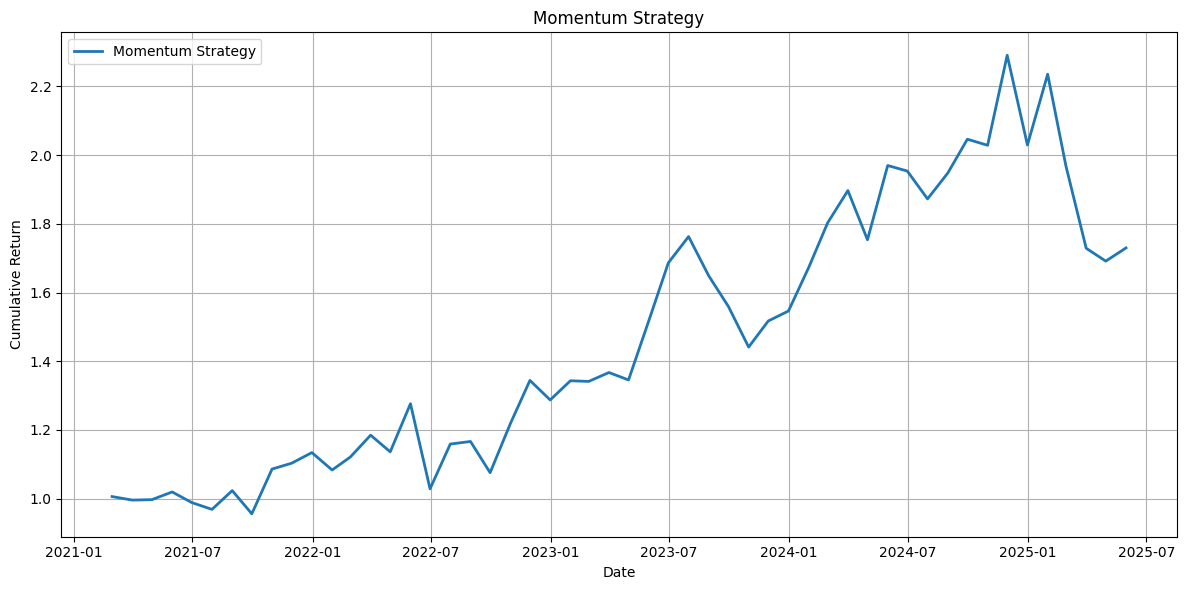

C:\Users\agand\AppData\Local\Temp\ipykernel_25948\1882173212.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return = df[-1] / df[0] - 1
C:\Users\agand\AppData\Local\Temp\ipykernel_25948\1882173212.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = (df[-1] / df[0])**(1/n_years) - 1


Start                            2021-02-28 00:00:00
End                              2025-05-31 00:00:00
Duration                          1553 days 00:00:00
Exposure Time [%]                              100.0
Equity Final [$]                        17297.184155
Equity Peak [$]                         22903.185729
Return [%]                                 71.907117
Buy & Hold Return [%]                      71.907117
Return (Ann.) [%]                          13.589647
Volatility (Ann.) [%]                      26.581242
CAGR [%]                                   13.589647
Sharpe Ratio                                 0.51125
Sortino Ratio                                0.93737
Calmar Ratio                                0.519578
Alpha [%]                                        0.0
Beta                                             1.0
Max. Drawdown [%]                         -26.155148
Avg. Drawdown [%]                          -5.301689
Max. Drawdown Duration             182 days 00

In [53]:
mom = momentum_strategy('2020-01-01', '2025-06-01')
mom.run()


## Factor investing strategy

In [28]:
import yfinance as yf
import time
import numpy as np


### Screener

In [35]:
class factor_investing_screener:

    def __init__(self, data_loader, tickers):
        self.loader = data_loader
        self.tickers = tickers
        self.passed = []

    def _get_features(self):
        for ticker in self.tickers:
            info = self.loader.get_fundamentals(ticker)
            # Check all required keys exist
            required_keys = [
                'priceToBook', 'trailingPE', 'forwardPE', 'enterpriseToEbitda',
                'debtToEquity', 'returnOnEquity', 'returnOnAssets', 'grossMargins',
                'operatingMargins', 'freeCashflow', 'revenueGrowth', 'earningsGrowth',
                'beta', 'marketCap'
            ]

            missing_keys = [k for k in required_keys if k not in info or info[k] is None]
            if missing_keys:
                print(f"[!] Skipping {ticker} — missing keys: {missing_keys}")
                continue


            if all(k in info and info[k] is not None for k in required_keys):
                self.passed.append({
                    'ticker': ticker,
                    'p_b': info['priceToBook'],
                    'pe_ttm': info['trailingPE'],
                    'pe_forward': info['forwardPE'],
                    'ev_ebitda': info['enterpriseToEbitda'],
                    'debt_to_equity': info['debtToEquity'],
                    'roe': info['returnOnEquity'],
                    'roa': info['returnOnAssets'],
                    'gross_margin': info['grossMargins'],
                    'operating_margin': info['operatingMargins'],
                    'fcf': info['freeCashflow'],
                    'revenue_growth': info['revenueGrowth'],
                    'earnings_growth': info['earningsGrowth'],
                    'beta': info['beta'],
                    'market_cap': info['marketCap']
                })
            time.sleep(0.2)  # avoid hitting API rate limits
        return self.passed 
    
    def choose_stocks(self, top_n=10):
        self._get_features()
        df = pd.DataFrame(self.passed)

        if df.empty:
            raise ValueError("No data available to screen.")

        # Invert value metrics: lower is better
        df['p_b_rank'] = df['p_b'].rank(ascending=True)
        df['pe_ttm_rank'] = df['pe_ttm'].rank(ascending=True)
        df['pe_forward_rank'] = df['pe_forward'].rank(ascending=True)
        df['ev_ebitda_rank'] = df['ev_ebitda'].rank(ascending=True)

        # Quality metrics: higher is better
        df['roe_rank'] = df['roe'].rank(ascending=False)
        df['roa_rank'] = df['roa'].rank(ascending=False)
        df['gross_margin_rank'] = df['gross_margin'].rank(ascending=False)
        df['operating_margin_rank'] = df['operating_margin'].rank(ascending=False)

        # Growth metrics: higher is better
        df['revenue_growth_rank'] = df['revenue_growth'].rank(ascending=False)
        df['earnings_growth_rank'] = df['earnings_growth'].rank(ascending=False)

        # Combine all ranks into a composite score (equal weighting for now)
        df['composite_score'] = df[
            [
                'p_b_rank', 'pe_ttm_rank', 'pe_forward_rank', 'ev_ebitda_rank',
                'roe_rank', 'roa_rank', 'gross_margin_rank', 'operating_margin_rank',
                'revenue_growth_rank', 'earnings_growth_rank'
            ]
        ].mean(axis=1)

        df_sorted = df.sort_values(by='composite_score')
        top_stocks = df_sorted.head(top_n).reset_index(drop=True)

        return top_stocks
            
            

### Stategy

In [ ]:
class factor_investing_strategy():



    def __init__(self, start_date, end_date, commission, screener, data_loader):
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.commission = commission / 100
        self.screener = screener
        self.loader = data_loader
        self.portfolio = []
        self.returns = []

    def get_stocks(self, date):
        top_stocks = self.screener.choose_stocks()
        return top_stocks['ticker'].tolist()
    
    def backtest(self, ):


In [41]:
dl = data_loader()
ticker = ['AAPL', 'JPM', 'NVDA', 'F', "GOOGL", "BRK.B"]
fic = factor_investing_screener(dl, tickers)
fis = factor_investing_strategy('2025-01-01', '2025-02-01', 0.02, fic)
tickers = fis.get_stocks(0)

[!] Skipping JPM — missing keys: ['enterpriseToEbitda', 'debtToEquity', 'freeCashflow']
[!] Skipping UNH — missing keys: ['earningsGrowth']


In [55]:
tickers['ticker'].tolist()

['NVDA', 'F']